<a href="https://colab.research.google.com/github/sheltauro/makemore/blob/main/bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
read_data = requests.get('https://raw.githubusercontent.com/sheltauro/makemore/main/data/names.txt').content
read_data = read_data.splitlines()

In [2]:
words = [str(rd, 'UTF-8') for rd in read_data]

In [3]:
min(len(w) for w in words)

2

In [4]:
max(len(w) for w in words)

15

In [5]:
b = {}
for w in words:
  # Create an array with a special start token. This will allow us to extract additional info about the first and last element.
  chs = ['<S>'] + list(w) + ['<E>']
  for ch1, ch2 in zip(chs, chs[1:]):
    bigram = (ch1, ch2)
    b[bigram] = b.get(bigram, 0) + 1

In [ ]:
sorted(b.items(), key = lambda kv : kv[1], reverse = True)

In [7]:
import torch

In [8]:
N = torch.zeros((27, 27), dtype = torch.int32)

In [9]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [10]:
for w in words:
  # Create an array with a special start/end token. This will allow us to extract additional info about the first and last element.
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    N[ix1, ix2] += 1

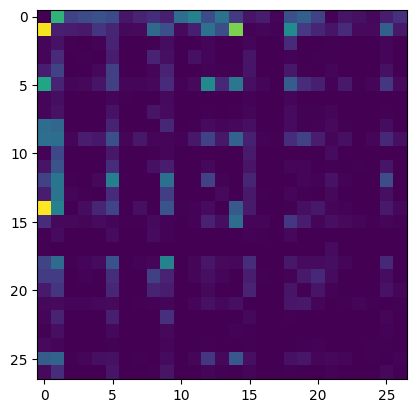

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(N)

In [12]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [13]:
g = torch.Generator().manual_seed(2147483647)
torch.multinomial(p, num_samples=1, replacement=True, generator=g)

tensor([10])

In [14]:
# We can do model smoothing by adding numbers to every element of the N matrix
P = N.float()
P /= P.sum(1, keepdim=True)
# Read broadcasting semantics for torch

In [15]:
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  out = []
  ix = 0
  while True:
    p = P[ix]
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

junide.
janasah.
p.
cony.
a.


In [74]:
log_likelihood = 0.0
n = 0
for w in words:
  # Create an array with a special start/end token. This will allow us to extract additional info about the first and last element.
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    prob = P[ix1, ix2]
    logprob = torch.log(prob)
    log_likelihood += logprob
    n += 1
    # print(f'{ch1}{ch2}: {prob:.4f} {logprob:.4f}')

nll =-log_likelihood
print(f'{nll=}')
print(f'{nll/n=}')

nll=tensor(559891.7500)
nll/n=tensor(2.4541)


In [17]:
# likelihood :- Product of probabilities
# log likelihood:- Log of the product of probabilities = Sum of log of probabilities
# log(a*b*c) = log(a) + log(b) + log(c)
# We'd prefer negative log likelihood

##Neural network based model

In [18]:
# create the training set of bigrams
xs, ys = [], []

for w in words[:1]:
  # Create an array with a special start/end token. This will allow us to extract additional info about the first and last element.
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)

# Beware of torch.tensor && torch.Tensor(this is a class)
xs = torch.tensor(xs)
ys = torch.tensor(ys) 

In [19]:
print(xs, ys)

tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


In [37]:
import torch.nn.functional as F

In [70]:
# create the dataset

xs, ys = [], []
for w in words:
  # Create an array with a special start/end token. This will allow us to extract additional info about the first and last element.
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

num = xs.nelement()
print('number of examples: ', num)

g = torch.Generator().manual_seed(2147483647)
# By passing in requires_grad, we tell pytorch that we want to calculate the gradient.
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples:  228146


In [ ]:
# gradient descent.
for k in range(200):
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = (xenc @ W) # log-counts
  counts = logits.exp()
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  # btw: The last 2 lines here are together called softmax.
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean() # Added regularization loss
  print(loss.item())

  # backward pass
  W.grad = None # set to zero the gradient.
  loss.backward()

  # update
  W.data += -50 * W.grad